In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8954cb25-037d-89a5-4cc5-f40f4515d503)


In [ ]:
!unzip /content/drive/Shareddrives/DATASET/ndsc-product-matching.zip -d /content/data/

In [ ]:
# !mkdir /content/outputs/
# !mkdir /content/outputs/cache/
# !mkdir /content/outputs/cache/dump.tfcache

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ImageFile.LOAD_TRUNCATED_IMAGES = True

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
class cfg:
    DATA_PATH = '/content/data'
    IMG_TRAIN_PATH = os.path.sep.join([DATA_PATH, 'training_img', 'training_img'])
    IMG_TEST_PATH = os.path.sep.join([DATA_PATH, 'test_img', 'test_img'])
    CSV_TRAIN_PATH = os.path.sep.join([DATA_PATH, 'new_training_set.csv'])
    CSV_TEST_PATH = os.path.sep.join([DATA_PATH, 'new_test_set.csv'])

    IMG_SIZE = 224
    IMG_SHAPE = (224, 224, 3)
    BATCH_SIZE = 16
    EPOCHS = 25
    BASE_OUTPUT = '/content/outputs'

In [ ]:
train_df = pd.read_csv(cfg.CSV_TRAIN_PATH, index_col=0)
train, hold = train_test_split(train_df, test_size=0.3, random_state=42)
valid, test = train_test_split(hold, test_size=0.3, random_state=42)

train_data = train.to_numpy()
valid_data = valid.to_numpy()
test_data = test.to_numpy()

## Create Dataset

In [ ]:
default_stop_words = [
    'atau', 'dan', 'and', 'murah', 'grosir',
    'untuk', 'termurah', 'cod', 'terlaris', 'bisacod', 'terpopuler',
    'bisa', 'terbaru', 'tempat', 'populer', 'di', 'sale', 'bayar', 'flash',
    'promo', 'seler', 'in', 'salee', 'diskon', 'gila', 'starseller', 'seller'
]

def preprocess_text(text):
    s = str(text).lower()
    s = ' '.join([word for word in s.split() if word not in default_stop_words])
    s = re.sub('&', ' and ', s)
    s = re.sub('/', 'atau', s, count=1)
    s = re.sub(r"[^a-zA-Z0-9]+", ' ', s)
    s = re.sub(' s ', 's ', s)
    s = re.sub(r"([0-9]+(\.[0-9]+)?)", r" \1 ", s).strip()
    return s

def preprocess_data(data, image_path):
    data[:,0] = np.array(list(map(preprocess_text, data[:,0])))
    data[:,2] = np.array(list(map(preprocess_text, data[:,2])))
    data[:,1] = image_path+'/'+data[:,1]
    data[:,3] = image_path+'/'+data[:,3]
    return data

In [ ]:
%%time
train_data = preprocess_data(train_data, cfg.IMG_TRAIN_PATH)
valid_data = preprocess_data(valid_data, cfg.IMG_TRAIN_PATH)
test_data = preprocess_data(test_data, cfg.IMG_TRAIN_PATH)

CPU times: user 314 ms, sys: 3.05 ms, total: 317 ms
Wall time: 319 ms


In [ ]:
def image_loader(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3, try_recover_truncated=True)
    img = tf.image.resize(img, size=[cfg.IMG_SIZE, cfg.IMG_SIZE])
    return img

def load_dataset(title_1, title_2, image_1, image_2, label):
    img_1 = image_loader(image_1)
    img_2 = image_loader(image_2)
    return title_1, title_2, img_1, img_2, label

def map_func(title_1, title_2, image_1, image_2, label):
    return {
        'title_1': title_1,
        'title_2': title_2,
        'image_1': image_1,
        'image_2': image_2
    }, label

In [ ]:
def create_dataset(data, batch_size=cfg.BATCH_SIZE):
    title_1 = data[:,0]
    title_2 = data[:,2]
    image_1 = data[:,1]
    image_2 = data[:,3]
    label = np.array(data[:,4], dtype='int')

    ds = tf.data.Dataset.from_tensor_slices(
        (title_1, title_2, image_1, image_2, label)
    )

    ds = ds.map(load_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.map(map_func, num_parallel_calls=AUTOTUNE)
    # ds = ds.cache('/content/outputs/cache/dump.tfcache') 
    # ds = ds.shuffle(buffer_size=1024)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
%%time
train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data)

CPU times: user 620 ms, sys: 391 ms, total: 1.01 s
Wall time: 5.55 s


Label 1
b'tas ransel anak karakter aneka motif backpack impor'
b'tas ransel anak karakter aneka motif backpack import atau tas anak mini ransel karakter backpack kids'


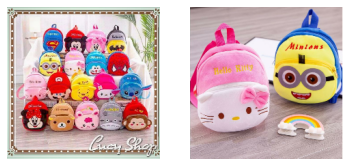

In [ ]:
for _data, _label in valid_ds.unbatch().take(1):
    print('Label {}'.format(_label.numpy()))
    print(_data['title_1'].numpy())
    print(_data['title_2'].numpy())
    f, ax = plt.subplots(1,2)
    ax[0].imshow(_data['image_1'].numpy().astype('int'))
    ax[1].imshow(_data['image_2'].numpy().astype('int'))
    ax[0].axis('off')
    ax[1].axis('off')

## Model

In [ ]:
from tensorflow.keras.applications import VGG16, vgg16
from tensorflow.keras.regularizers import l2

In [ ]:
def create_vgg16_extractor(rate=0.3, reg=0.01):
    base_model = VGG16(include_top=False, input_shape=cfg.IMG_SHAPE)
    base_model.trainable = False

    inputs = layers.Input(shape=cfg.IMG_SHAPE, name='input_image')
    x = vgg16.preprocess_input(inputs)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(rate)(x)
    x = layers.Dense(units=128, activation='relu', kernel_regularizer=l2(reg))(x)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(units=32, activation='relu',
                           kernel_regularizer=l2(reg), 
                           name='output_image')(x)

    model = Model(inputs, outputs, name='image_extractor_vgg16')
    return model

In [ ]:
def create_text_extractor(vectorize_layer, rate=0.3, reg=0.01):
    inputs = layers.Input(shape=(1,), dtype='string', name='input_text')
    x = vectorize_layer(inputs)
    x = layers.Embedding(len(vectorize_layer.get_vocabulary()),
                         output_dim=32,
                         mask_zero=True)(x)
    x = layers.GRU(64)(x)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(16, activation='relu', kernel_regularizer=l2(reg), name='output_text')(x)
    model = Model(inputs, outputs, name='text_extractor')
    return model

In [ ]:
def euclidean_distance(vectors):
	(feats_a, feats_b) = vectors
	num_squared = K.sum(K.square(feats_a - feats_b), axis=1,
		keepdims=True)
	return K.sqrt(K.maximum(num_squared, K.epsilon()))

In [ ]:
def create_vectorize_layer(vocab, vocab_size=10000, sequence_length=24):
    vectorize_layer = layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)
    vectorize_layer.adapt(vocab)
    return vectorize_layer

In [ ]:
tf.keras.backend.clear_session()

title_1 = layers.Input(shape=(1,), dtype='string', name='title_1')
title_2 = layers.Input(shape=(1,), dtype='string', name='title_2')
image_1 = layers.Input(shape=cfg.IMG_SHAPE, name='image_1')
image_2 = layers.Input(shape=cfg.IMG_SHAPE, name='image_2')

vocab = np.concatenate([train_data[:,0], train_data[:,2],
                        valid_data[:,0], valid_data[:,2]])
vectorize_layer = create_vectorize_layer(vocab)
text_extractor = create_text_extractor(vectorize_layer, rate=0.2, reg=0.001)
feats_text_1 = text_extractor(title_1)
feats_text_2 = text_extractor(title_2)

image_extractor = create_vgg16_extractor(rate=0.2, reg=0.001)
feats_image_1 = image_extractor(image_1)
feats_image_2 = image_extractor(image_2)

feats_1 = layers.Concatenate(name='feats_1')([feats_text_1, feats_image_1])
feats_2 = layers.Concatenate(name='feats_2')([feats_text_2, feats_image_2])

distance = layers.Lambda(euclidean_distance)([feats_1, feats_2])
outputs = layers.Dense(1, activation="sigmoid", dtype='float32', name='final_dense')(distance)
model = Model(inputs=[title_1, title_2, image_1, image_2], outputs=outputs, name='siamese_networks')

In [ ]:
model.summary()

Model: "siamese_networks"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
image_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
title_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
___________________________________________________________________________________

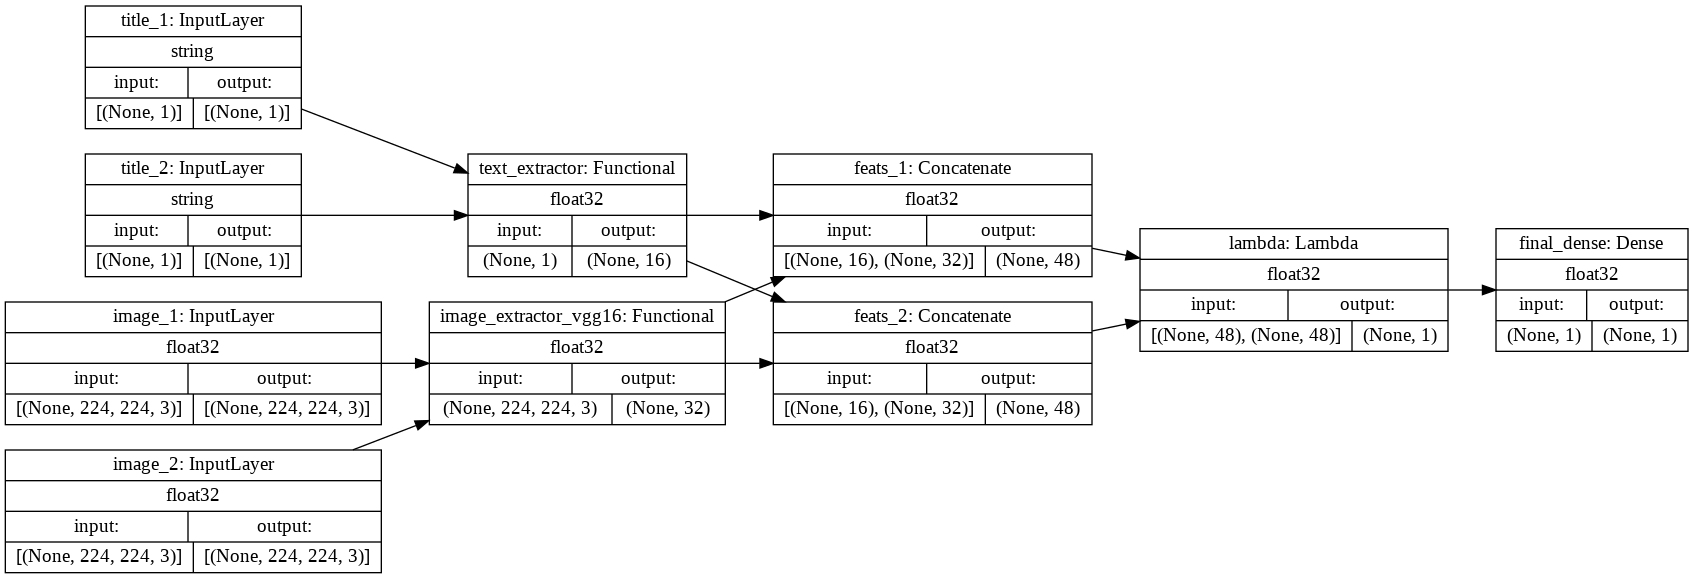

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR', show_dtype=True)

In [ ]:
# metrics_f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1')
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=tfa.losses.ContrastiveLoss())

## Training

In [ ]:
steps_per_epoch = len(train_data)//cfg.BATCH_SIZE
validation_steps = len(valid_data)//cfg.BATCH_SIZE

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=30,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/30
445/445 [==============================] - 90s 189ms/step - loss: 0.4680 - val_loss: 0.2822
Epoch 2/30
445/445 [==============================] - 82s 185ms/step - loss: 0.2791 - val_loss: 0.2646
Epoch 3/30
445/445 [==============================] - 82s 185ms/step - loss: 0.2655 - val_loss: 0.2572
Epoch 4/30
445/445 [==============================] - 82s 185ms/step - loss: 0.2606 - val_loss: 0.2536
Epoch 5/30
445/445 [==============================] - 82s 184ms/step - loss: 0.2560 - val_loss: 0.2529
Epoch 6/30
445/445 [==============================] - 82s 184ms/step - loss: 0.2573 - val_loss: 0.2529
Epoch 7/30
445/445 [==============================] - 82s 183ms/step - loss: 0.2526 - val_loss: 0.2524
Epoch 8/30
445/445 [==============================] - 82s 185ms/step - loss: 0.2539 - val_loss: 0.2299
Epoch 9/30
445/445 [==============================] - 82s 184ms/step - loss: 0.2388 - val_loss: 0.2187
Epoch 10/30
445/445 [==============================] - 82s 185ms/step - l

In [ ]:
# metrics_f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1')
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tfa.losses.ContrastiveLoss())

history_2 = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=30,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/30
445/445 [==============================] - 91s 189ms/step - loss: 0.1797 - val_loss: 0.1729
Epoch 2/30
445/445 [==============================] - 82s 184ms/step - loss: 0.1765 - val_loss: 0.1714
Epoch 3/30
445/445 [==============================] - 82s 185ms/step - loss: 0.1736 - val_loss: 0.1701
Epoch 4/30
445/445 [==============================] - 82s 184ms/step - loss: 0.1684 - val_loss: 0.1702
Epoch 5/30
445/445 [==============================] - 82s 184ms/step - loss: 0.1716 - val_loss: 0.1699
Epoch 6/30
445/445 [==============================] - 82s 185ms/step - loss: 0.1724 - val_loss: 0.1690
Epoch 7/30
445/445 [==============================] - 82s 184ms/step - loss: 0.1717 - val_loss: 0.1685
Epoch 8/30
445/445 [==============================] - 82s 185ms/step - loss: 0.1741 - val_loss: 0.1673
Epoch 9/30
445/445 [==============================] - 82s 185ms/step - loss: 0.1706 - val_loss: 0.1675
Epoch 10/30
445/445 [==============================] - 82s 185ms/step - l

In [ ]:
model.save('/content/drive/MyDrive/Colab Projects/proudut-pair-siamese-networks/output/version-3',save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Projects/proudut-pair-siamese-networks/output/version-3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Projects/proudut-pair-siamese-networks/output/version-3/assets


## Predict

### Create dataset

In [ ]:
def load_predict_dataset(title_1, title_2, image_1, image_2):
    img_1 = image_loader(image_1)
    img_2 = image_loader(image_2)
    return title_1, title_2, img_1, img_2

def map_predict_func(title_1, title_2, image_1, image_2):
    return {
        'title_1': title_1,
        'title_2': title_2,
        'image_1': image_1,
        'image_2': image_2
    }

def create_predict_data(data, batch_size=cfg.BATCH_SIZE):
    title_1 = data[:,0]
    title_2 = data[:,2]
    image_1 = data[:,1]
    image_2 = data[:,3]

    ds = tf.data.Dataset.from_tensor_slices(
        (title_1, title_2, image_1, image_2)
    )

    ds = ds.map(load_predict_dataset, num_parallel_calls=AUTOTUNE)
    ds = ds.map(map_predict_func, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
# pred_data = np.concatenate([train_data, valid_data])
pred_data = test_data.copy()
_pred_data = create_predict_data(pred_data)
pred = model.predict(_pred_data)

### Find threshold

In [ ]:
threshold = np.linspace(0, 1, 1001)
acc_th = []
f1_th = []
for i in threshold:
    acc_th.append(accuracy_score(pred_data[:,4].astype(int), np.hstack(np.where(pred > i, 0, 1))))
    f1_th.append(f1_score(pred_data[:,4].astype(int), np.hstack(np.where(pred > i, 0, 1))))

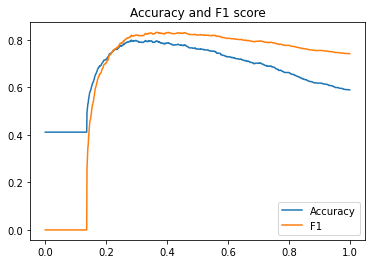

Highest F1 score: 0.8312387791741472
Threshold: 0.366


In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(threshold, acc_th, label='Accuracy')
plt.plot(threshold, f1_th, label='F1')
plt.legend(loc='lower right')
plt.title('Accuracy and F1 score')
plt.show();

th = threshold[np.argmax(f1_th)]
print('Highest F1 score: {}'.format(np.max(f1_th)))
print('Threshold: {}'.format(th))

### Score

In [ ]:
print('Accuracy: {}'.format(accuracy_score(pred_data[:,4].astype(int), np.hstack(np.where(pred > th, 0, 1)))))
print('F1 Score: {}'.format(f1_score(pred_data[:,4].astype(int), np.hstack(np.where(pred > th, 0, 1)))))

Accuracy: 0.7949836423118866
F1 Score: 0.8312387791741472


In [ ]:
check = pd.DataFrame(pred_data, columns=['title_1', 'image_1', 'title_2', 'image_2', 'Label'])
check['pred'] = np.hstack(np.where(pred > th, 0, 1))
check['distance'] = pred
check

,title_1,image_1,title_2,image_2,Label,pred,distance
0,vaseline lotion healthy white uv lightening 4...,/content/data/training_img/training_img/ff80d3...,vaseline healthy white lotion 400 ml,/content/data/training_img/training_img/2c2752...,0,1,0.299673
1,10 pcs fantastis berwarna warni selotip diary...,/content/data/training_img/training_img/a684e3...,10 pcs set masking tape agugu antibes morning...,/content/data/training_img/training_img/7cac36...,1,1,0.136746
2,27 an id dompet wanita d 665 atau d 07 domp...,/content/data/training_img/training_img/eae263...,dompet wanita d 665 atau d 07 import dompet...,/content/data/training_img/training_img/358c4a...,0,1,0.277055
3,dua sisi bolak balik topi bucket atau fisherma...,/content/data/training_img/training_img/cb360c...,gd topi bucket atau fisherman lipat dua sisi m...,/content/data/training_img/training_img/64e1ca...,0,0,0.945747
4,selimut topi karakter carter just to youatauko...,/content/data/training_img/training_img/220407...,selimut animal topi atau selimut topi karakter...,/content/data/training_img/training_img/d72304...,0,1,0.223119
...,...,...,...,...,...,...,...
912,pepoy shop stelan piyama baju tidur tangan pan...,/content/data/training_img/training_img/5a08b1...,pepoy shop stelan baju tidur tangan panjang pp...,/content/data/training_img/training_img/0d1cb8...,0,1,0.200695
913,tahun baru sepatu slip on venom,/content/data/training_img/training_img/c18e54...,bl sepatu slip on venom original premium high ...,/content/data/training_img/training_img/5f0eab...,1,1,0.162921
914,luckymama refill tinta pen isi ulang 2 65 ...,/content/data/training_img/training_img/53a3e4...,bonita 20 pcs gel pen refill 0 5 mm penpo...,/content/data/training_img/training_img/1e9bb6...,1,1,0.215008
915,bolt repack 1 kg atau cat food dray food paka...,/content/data/training_img/training_img/7a7422...,maxi repack 1 kg atau makanan kucing pakan he...,/content/data/training_img/training_img/a99f07...,0,0,0.485776


In [ ]:
check_data = check[check['Label']!=check['pred']].to_numpy()

import matplotlib.image as mpimg


170
Label 1
Pred 0
Distance 0.392335444688797
title 1: madame gie briliant moist velvet and smooth lip liquide lip cream
title 2: bisacod madame gie briliant moist velvet and smooth lip liquide lip cream


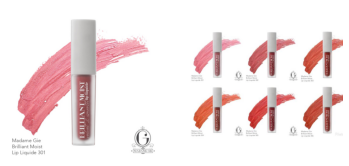

In [ ]:
i = np.random.randint(len(check_data))
print(i)
print('Label {}'.format(check_data[i,4]))
print('Pred {}'.format(check_data[i,5]))
print('Distance {}'.format(check_data[i,6]))
print('title 1: {}'.format(check_data[i,0]))
print('title 2: {}'.format(check_data[i,2]))
f, ax = plt.subplots(1,2)
ax[0].imshow(mpimg.imread(check_data[i,1]))
ax[1].imshow(mpimg.imread(check_data[i,3]))
ax[0].axis('off')
ax[1].axis('off')
plt.show();

In [ ]:
# Something wrong with image feature extractor
# TO DO: fix image extractor
# - Add Dense
# - Decrease dropout
# - Add neuron
# - change to EfficientNet